<a href="https://colab.research.google.com/github/Avani10/CNNs-on-Tabular-data/blob/master/Results_on_Tabular_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tabular Data Load

In [0]:
from fastai.tabular import *

In [0]:
path = untar_data(URLs.ADULT_SAMPLE)
df = pd.read_csv(path/'adult.csv')

In [0]:
df.head(2)

age workclass  fnlwgt  ... hours-per-week  native-country salary
0   49   Private  101320  ...             40   United-States  >=50k
1   44   Private  236746  ...             45   United-States  >=50k

[2 rows x 15 columns]

In [0]:
#Used this to run profiling code
#!pip install -U pandas-profiling

In [0]:
import pandas_profiling
df.profile_report()

# Method 0. Fastai - neural network

In [0]:
dep_var = 'salary'
cat_names = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race']
cont_names = ['age', 'fnlwgt', 'education-num']
procs = [FillMissing, Categorify, Normalize]

In [0]:
test = TabularList.from_df(df.iloc[800:10567].copy(), path=path, cat_names=cat_names, cont_names=cont_names)

In [0]:
data = (TabularList.from_df(df, path=path, cat_names=cat_names, cont_names=cont_names, procs=procs)
                           .split_by_idx(list(range(800,10567)))
                           .label_from_df(cols=dep_var)
                           .add_test(test)
                           .databunch())

In [0]:
learn = tabular_learner(data, layers=[600,300], metrics=accuracy)

In [0]:
learn.fit(1, 1e-2)

In [0]:
learn.fit(10, 1e-2)

In [0]:
learn.save('stage-1')

In [0]:
path.ls()

[PosixPath('/root/.fastai/data/adult_sample/models'),
 PosixPath('/root/.fastai/data/adult_sample/adult.csv'),
 PosixPath('/root/.fastai/data/adult_sample/export.pkl')]

In [0]:
path

PosixPath('/root/.fastai/data/adult_sample')

In [0]:
! ls /root/.fastai/data/adult_sample/models

mini_train.pth	stage-1a.pth  stage-1.pth  tmp.pth


In [0]:
learn.unfreeze()

In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


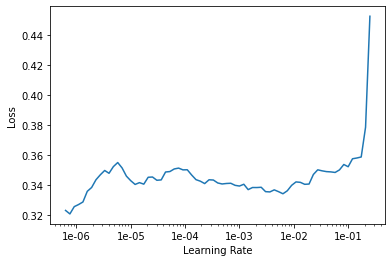

In [0]:
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(2,1e-2, wd=0.3)

In [0]:
learn.fit_one_cycle(12,1e-6, wd=0.2)

In [0]:
learn.save('stage-1a')

In [0]:
learn.load('stage-1a')

Learner(data=TabularDataBunch;

Train: LabelList (22794 items)
x: TabularList
workclass  Private; education  Assoc-acdm; marital-status  Married-civ-spouse; occupation #na#; relationship  Wife; race  White; education-num_na False; age 0.7708; fnlwgt -0.8358; education-num 0.7505; ,workclass  Private; education  Masters; marital-status  Divorced; occupation  Exec-managerial; relationship  Not-in-family; race  White; education-num_na False; age 0.4035; fnlwgt 0.4581; education-num 1.5339; ,workclass  Private; education  HS-grad; marital-status  Divorced; occupation #na#; relationship  Unmarried; race  Black; education-num_na True; age -0.0373; fnlwgt -0.8848; education-num -0.0329; ,workclass  Self-emp-inc; education  Prof-school; marital-status  Married-civ-spouse; occupation  Prof-specialty; relationship  Husband; race  Asian-Pac-Islander; education-num_na False; age -0.0373; fnlwgt -0.7256; education-num 1.9256; ,workclass  Self-emp-not-inc; education  7th-8th; marital-status  Married

In [0]:
learn.fit_one_cycle(12,1e-2, wd=0.2)

In [0]:
learn.fit_one_cycle(12,1e-2, wd=0.2)

In [0]:
learn.fit_one_cycle(12,1e-2)

In [0]:
interp = ClassificationInterpretation.from_learner(learn)


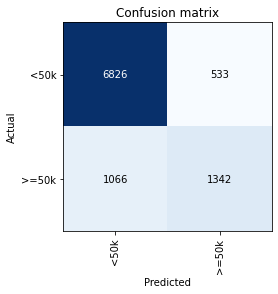

In [0]:
interp.plot_confusion_matrix()

In [0]:
(interp.confusion_matrix()[0,0]+interp.confusion_matrix()[1,1])/np.sum(interp.confusion_matrix())

0.836285451008498

In [0]:
pred=[]
for i in range(len(test)):
     k=str(learn.predict(test[i])[0])
     pred.append(k)

In [0]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report
y_actu = list(df.iloc[800:10567,14])
y_pred = pred
print(confusion_matrix(y_actu, y_pred))

[[7283   76]
 [2391   17]]


In [0]:
accuracy_score(y_actu, y_pred)

0.7474147640012286

In [0]:
print(classification_report(y_actu, y_pred))

              precision    recall  f1-score   support

        <50k       0.75      0.99      0.86      7359
       >=50k       0.18      0.01      0.01      2408

    accuracy                           0.75      9767
   macro avg       0.47      0.50      0.43      9767
weighted avg       0.61      0.75      0.65      9767



In [0]:
print(precision_recall_fscore_support(y_actu, y_pred,zero_division=1))

(array([0.752843, 0.182796]), array([0.989673, 0.00706 ]), array([0.855164, 0.013595]), array([7359, 2408]))


In [0]:
np.sum(interp.confusion_matrix())

9767

# Ensemble Methods
### Part 1. Converting categorical variables to matrices for further use in model training

In [0]:
df.columns=['age', 'workclass', 'fnlwgt', 'education', 'education_num',
       'marital_status', 'occupation', 'relationship', 'race', 'sex',
       'capital_gain', 'capital_loss', 'hours_per_week', 'native_country',
       'salary']

In [0]:
from sklearn.model_selection import train_test_split
from patsy import dmatrices

In [0]:
formula = 'salary ~ 0 + age + workclass + fnlwgt + education + education_num + ' + \
          'marital_status + occupation + relationship + race + sex + ' \
          'capital_gain + capital_loss + hours_per_week + native_country'
Y, X = dmatrices(formula, df, return_type='dataframe')

In [0]:
Y.head(2)

salary[<50k]  salary[>=50k]
1           0.0            1.0
3           0.0            1.0

In [0]:
y = Y['salary[>=50k]'].values

In [0]:
# Creating train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

### Part 2. Trying different ensemmble methods
# Method 1. Random Forest

In [0]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_features': ['auto', 'sqrt'],
    'max_depth' : [6,7,8],
    'criterion' :['gini', 'entropy'],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300]
}

# Create a based model
rf = RandomForestClassifier(random_state=10)
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)
# Fit the grid search to the data
grid_search.fit(X_train, y_train)


best_grid = grid_search.best_estimator_
print(grid_search.best_params_)

Fitting 3 folds for each of 324 candidates, totalling 972 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   44.6s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed:  7.5min
[Parallel(n_jobs=-1)]: Done 644 tasks      | elapsed: 13.7min
[Parallel(n_jobs=-1)]: Done 972 out of 972 | elapsed: 21.3min finished


{'bootstrap': True, 'criterion': 'gini', 'max_depth': 8, 'max_features': 'auto', 'min_samples_leaf': 4, 'min_samples_split': 8, 'n_estimators': 200}


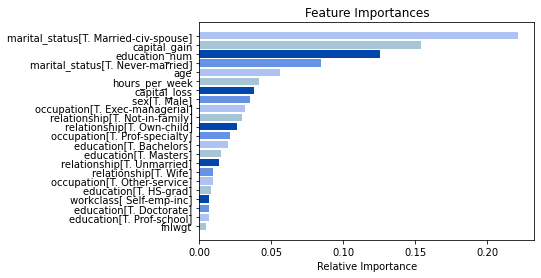

marital_status[T. Married-civ-spouse]    0.221528
capital_gain                             0.153933
education_num                            0.125641
marital_status[T. Never-married]         0.084541
age                                      0.055814
                                           ...   
native_country[T. Ireland]               0.000000
occupation[T. Armed-Forces]              0.000000
native_country[T. Scotland]              0.000000
native_country[T. Ecuador]               0.000000
native_country[T. Hungary]               0.000000
Length: 101, dtype: float64


 The accuracy score for test data is :  0.8496437552388936


 Classification Report 

               precision    recall  f1-score   support

         0.0       0.86      0.96      0.91      7171
         1.0       0.82      0.51      0.63      2373

    accuracy                           0.85      9544
   macro avg       0.84      0.74      0.77      9544
weighted avg       0.85      0.85      0.84      9544



 Con

In [0]:
pred=best_grid.predict(X_test)

# Importance of features, Confusion matrix & Accuracy score
mycolors=['#a6c6d7','#aec3f3','#6793e6','#0146ab']
rf.fit(X_train, y_train)

from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
import pandas as pd

y_pred_rf = best_grid.predict_proba(X_train)[:,1]
fpr_rf, tpr_rf, _ = roc_curve(y_train, y_pred_rf)
y_pred_rft = best_grid.predict_proba(X_test)[:,1]
fpr_rft, tpr_rft, _ = roc_curve(y_test, y_pred_rft)

#Feature Importance

features = X.columns
importances = best_grid.feature_importances_
indices = np.argsort(importances)[-22:]
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color=mycolors, align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

# Gini Index

fi = pd.Series(best_grid.feature_importances_, index=X.columns.values)
print (fi.sort_values(ascending=False))

thresh=0.50
y_pred_train=[1 if x>thresh else 0 for x in y_pred_rf]
y_pred_test=[1 if x>thresh else 0 for x in y_pred_rft]

from sklearn import metrics
print ("\n\n The accuracy score for test data is : ", metrics.accuracy_score(y_test, y_pred_test))
print ("\n\n Classification Report \n\n",metrics.classification_report(y_test, y_pred_test))
print ("\n\n Confusion Matrix \n\n",metrics.confusion_matrix(y_test, y_pred_test))
from sklearn.metrics import roc_auc_score
print("\n\nThe ROC-AUC score of RF is", roc_auc_score(y_test, y_pred_rft))

0.9084441224877817


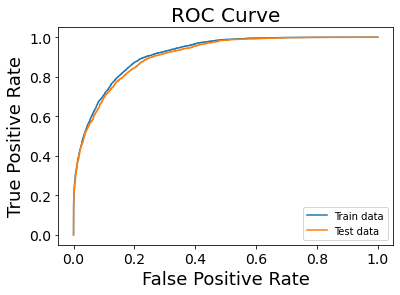

In [0]:
# AUC ROC score

from sklearn.metrics import roc_auc_score
print (roc_auc_score(y_test, y_pred_rft))

plt.plot(fpr_rf, tpr_rf, label='Train data')
plt.plot(fpr_rft, tpr_rft, label='Test data')
plt.legend(loc='best')
plt.xlabel('False Positive Rate', size =18)
plt.ylabel('True Positive Rate', size = 18)
plt.title('ROC Curve', size =20)
plt.axis('tight')
plt.tick_params(labelsize=14)

# Method 2. Gradient Boosting Classifier

In [0]:
from sklearn.ensemble import GradientBoostingClassifier

gbm=GradientBoostingClassifier(random_state=42)
param_grid = {
    "learning_rate": [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2],
    #"min_samples_split": np.linspace(0.1, 0.5, 12),
    #"min_samples_leaf": np.linspace(0.1, 0.5, 12),
    "max_depth":[3,5,8],
    "max_features":["log2","sqrt"],
    #"criterion": ["friedman_mse",  "mae"],
    #"subsample":[0.5, 0.618, 0.8, 0.85, 0.9, 0.95, 1.0],
    "n_estimators":[5,10,15]
    }
grid_search_gbm = GridSearchCV(gbm,param_grid, cv=5, n_jobs=-1, scoring = 'roc_auc')


# Fit the grid search to the data
grid_search_gbm.fit(X_train, y_train)

grid_search_gbm.fit(X_train, y_train)
print(grid_search_gbm.best_params_)

best_grid_gbm = grid_search_gbm.best_estimator_

{'learning_rate': 0.2, 'max_depth': 8, 'max_features': 'sqrt', 'n_estimators': 15}


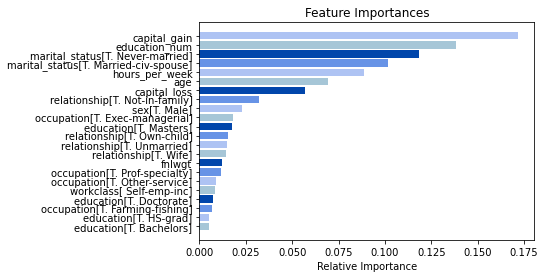

capital_gain                             0.171903
education_num                            0.138502
marital_status[T. Never-married]         0.118099
marital_status[T. Married-civ-spouse]    0.101592
hours_per_week                           0.088636
                                           ...   
occupation[T. Armed-Forces]              0.000000
native_country[T. Thailand]              0.000000
native_country[T. Cambodia]              0.000000
education[T. Preschool]                  0.000000
native_country[T. Columbia]              0.000000
Length: 101, dtype: float64


 The accuracy score for test data is :  0.8543587594300084


 Classification Report 

               precision    recall  f1-score   support

         0.0       0.87      0.95      0.91      7171
         1.0       0.79      0.57      0.66      2373

    accuracy                           0.85      9544
   macro avg       0.83      0.76      0.78      9544
weighted avg       0.85      0.85      0.85      9544



 Con

In [0]:
# Importance of features, Confusion matrix & Accuracy score

y_pred_gbm = best_grid_gbm.predict_proba(X_train)[:,1]
fpr_gbm, tpr_gbm, _ = roc_curve(y_train, y_pred_gbm)
y_pred_gbmt = best_grid_gbm.predict_proba(X_test)[:,1]
fpr_gbmt, tpr_gbmt, _ = roc_curve(y_test, y_pred_gbmt)


features = X.columns
importances = best_grid_gbm.feature_importances_
indices = np.argsort(importances)[-22:]
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color=mycolors, align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

# Gini Index

fi = pd.Series(best_grid_gbm.feature_importances_, index=X.columns.values)
print (fi.sort_values(ascending=False))

thresh=0.50
y_pred_train=[1 if x>thresh else 0 for x in y_pred_gbm]
y_pred_test=[1 if x>thresh else 0 for x in y_pred_gbmt]
print ("\n\n The accuracy score for test data is : ", metrics.accuracy_score(y_test, y_pred_test))
print ("\n\n Classification Report \n\n",metrics.classification_report(y_test, y_pred_test))
print ("\n\n Confusion Matrix \n\n",metrics.confusion_matrix(y_test, y_pred_test))
print("\n\nThe ROC-AUC score of GBM is", roc_auc_score(y_test, y_pred_gbmt))

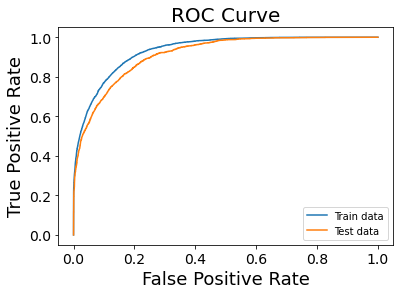

In [0]:
plt.plot(fpr_gbm, tpr_gbm, label='Train data')
plt.plot(fpr_gbmt, tpr_gbmt, label='Test data')
plt.legend(loc='best')
plt.xlabel('False Positive Rate', size =18)
plt.ylabel('True Positive Rate', size = 18)
plt.title('ROC Curve', size =20)
plt.axis('tight')
plt.tick_params(labelsize=14)

# Method 3. AdaBoostClassifier

In [0]:
from sklearn.ensemble import AdaBoostClassifier

# Create the parameter grid based on the results of random search 
parameters = {
    "algorithm" : ["SAMME", "SAMME.R"],
    "learning_rate": [0.01, 0.025, 0.05, 0.075, 0.1],
    #[0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2],
    "n_estimators":[5,10,15]
    }

# Create a base model
abc=AdaBoostClassifier(random_state=42)

# Instantiate the grid search model
# run grid search

grid_search_abc = GridSearchCV(abc,parameters, cv=5, scoring = 'roc_auc')
grid_search_abc.fit(X_train, y_train)

print (grid_search_abc.best_params_)
best_grid_abc = grid_search_abc.best_estimator_

{'algorithm': 'SAMME.R', 'learning_rate': 0.1, 'n_estimators': 15}


[36 95 97 98 25]


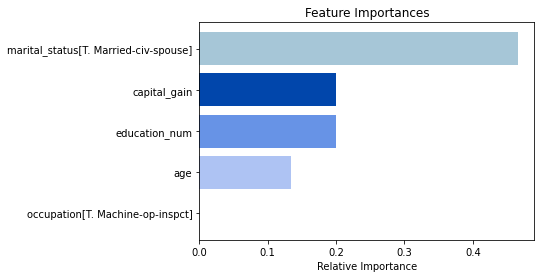

marital_status[T. Married-civ-spouse]    0.466667
capital_gain                             0.200000
education_num                            0.200000
age                                      0.133333
occupation[T. Machine-op-inspct]         0.000000
                                           ...   
native_country[T. Haiti]                 0.000000
native_country[T. Holand-Netherlands]    0.000000
native_country[T. Honduras]              0.000000
native_country[T. Hong]                  0.000000
workclass[ ?]                            0.000000
Length: 101, dtype: float64


 The accuracy score for test data is :  0.7900251466890192


 Classification Report 

               precision    recall  f1-score   support

         0.0       0.78      1.00      0.88      7171
         1.0       0.99      0.16      0.27      2373

    accuracy                           0.79      9544
   macro avg       0.88      0.58      0.57      9544
weighted avg       0.83      0.79      0.73      9544



 Con

In [0]:
# Fit the grid search to the data
best_grid_abc.fit(X_train, y_train)


y_pred_abc = best_grid_abc.predict_proba(X_train)[:,1]
fpr_abc, tpr_abc, _ = roc_curve(y_train, y_pred_abc)
y_pred_abct = best_grid_abc.predict_proba(X_test)[:,1]
fpr_abct, tpr_abct, _ = roc_curve(y_test, y_pred_abct)

#Feature Importance

features = X.columns
importances = best_grid_abc.feature_importances_
indices = np.argsort(importances)[-5:]
print(indices)
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color=mycolors, align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

# Gini Index

fi = pd.Series(best_grid_abc.feature_importances_, index=X.columns.values)
print (fi.sort_values(ascending=False))

thresh=0.50
y_pred_train=[1 if x>thresh else 0 for x in y_pred_abc]
y_pred_test=[1 if x>thresh else 0 for x in y_pred_abct]
from sklearn import metrics
print ("\n\n The accuracy score for test data is : ", metrics.accuracy_score(y_test, y_pred_test))
print ("\n\n Classification Report \n\n",metrics.classification_report(y_test, y_pred_test))
print ("\n\n Confusion Matrix \n\n",metrics.confusion_matrix(y_test, y_pred_test))
print("\n\nThe score of Adaboost is", roc_auc_score(y_test, y_pred_abct))

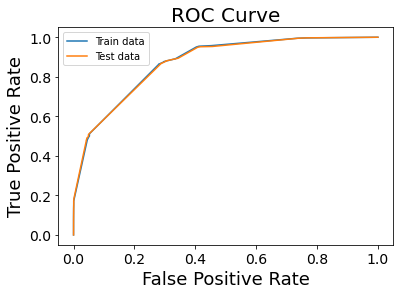

In [0]:
plt.plot(fpr_abc, tpr_abc, label='Train data')
plt.plot(fpr_abct, tpr_abct, label='Test data')
plt.legend(loc='best')
plt.xlabel('False Positive Rate', size =18)
plt.ylabel('True Positive Rate', size = 18)
plt.title('ROC Curve', size =20)
plt.axis('tight')
plt.tick_params(labelsize=14)